In [53]:
import numpy as np
from matplotlib import pyplot as plt
import random

import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchinfo import summary

from tqdm import tqdm

# CIFAR10-CNN

In [54]:
config = {
    'batch_size': 256,
    'shuffle': True,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'learning_rate': 0.01,
    'epochs': 100,
    'save_path': './models',
}


Files already downloaded and verified
Files already downloaded and verified


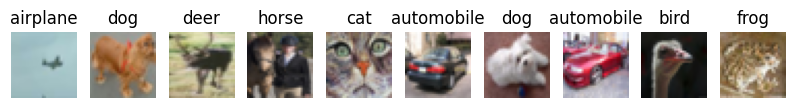

In [55]:
# fetch CIFAR10 dataset
train_data = CIFAR10(root='datasets', train=True, download=True, transform=ToTensor())
test_data = CIFAR10(root='datasets', train=False, download=True, transform=ToTensor())

train_dataloader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=config['shuffle'])
test_dataloader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=config['shuffle'])

label_text = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axs = plt.subplots(1, 10, figsize=(10,2))
for i in range(10):
    idx = random.choice(range(len(train_data)))
    axs[i].imshow(train_data[idx][0].permute(1,2,0))
    axs[i].axis('off')
    axs[i].set_title(label_text[train_data[idx][1]])
plt.show()

In [56]:
print(train_data[0][0].shape)

torch.Size([3, 32, 32])


In [57]:
# create a CNN network
class LeNet(torch.nn.Module):
    # LeNet-5
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5) # 32 * 32 * 3 -> 28 * 28 * 6
        self.pooling1 = torch.nn.MaxPool2d(2, 2) # 28 * 28 * 6 -> 14 * 14 * 6
        self.conv2 = torch.nn.Conv2d(6, 16, 5) # 14 * 14 * 6 -> 10 * 10 * 16
        self.pooling2 = torch.nn.MaxPool2d(2, 2) # 10 * 10 * 16 -> 5 * 5 * 16
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120) 
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.3)
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.sigmoid(x)
        x = self.pooling1(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        x = self.pooling2(x)
        x = x.view(-1, 5 * 5 * 16)
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = LeNet().to(config['device'])
summary(model,input_size=(config['batch_size'],3,32,32))


Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [256, 10]                 --
├─Conv2d: 1-1                            [256, 6, 28, 28]          456
├─Sigmoid: 1-2                           [256, 6, 28, 28]          --
├─MaxPool2d: 1-3                         [256, 6, 14, 14]          --
├─Conv2d: 1-4                            [256, 16, 10, 10]         2,416
├─Sigmoid: 1-5                           [256, 16, 10, 10]         --
├─MaxPool2d: 1-6                         [256, 16, 5, 5]           --
├─Linear: 1-7                            [256, 120]                48,120
├─Sigmoid: 1-8                           [256, 120]                --
├─Dropout: 1-9                           [256, 120]                --
├─Linear: 1-10                           [256, 84]                 10,164
├─Sigmoid: 1-11                          [256, 84]                 --
├─Dropout: 1-12                          [256, 84]                 --
├─L

In [63]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

# training
model.train()
train_loss_history = []
train_acc_history = []
for epoch in tqdm(range(config['epochs'])):
    running_loss = 0.0
    running_acc = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(config['device']), labels.to(config['device'])
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.argmax(output, 1)
        running_acc += (preds == labels).float().mean()
    train_loss = running_loss / len(train_dataloader)
    train_acc = running_acc / len(train_dataloader)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc.item())
    print(f'Epoch {epoch+1}/{config["epochs"]} Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        

  1%|          | 1/100 [00:10<16:49, 10.19s/it]

Epoch 1/100 Loss: 0.7827 Acc: 0.7230


  2%|▏         | 2/100 [00:20<16:38, 10.19s/it]

Epoch 2/100 Loss: 0.7681 Acc: 0.7288


  3%|▎         | 3/100 [00:30<16:35, 10.27s/it]

Epoch 3/100 Loss: 0.7744 Acc: 0.7285


  4%|▍         | 4/100 [00:41<16:31, 10.33s/it]

Epoch 4/100 Loss: 0.7690 Acc: 0.7281


  5%|▌         | 5/100 [00:51<16:23, 10.36s/it]

Epoch 5/100 Loss: 0.7671 Acc: 0.7278


  6%|▌         | 6/100 [01:01<16:13, 10.36s/it]

Epoch 6/100 Loss: 0.7721 Acc: 0.7294


  7%|▋         | 7/100 [01:12<16:00, 10.33s/it]

Epoch 7/100 Loss: 0.7815 Acc: 0.7248


  8%|▊         | 8/100 [01:23<16:11, 10.56s/it]

Epoch 8/100 Loss: 0.7745 Acc: 0.7254


  9%|▉         | 9/100 [01:33<15:55, 10.50s/it]

Epoch 9/100 Loss: 0.7747 Acc: 0.7278


 10%|█         | 10/100 [01:44<15:58, 10.65s/it]

Epoch 10/100 Loss: 0.7590 Acc: 0.7312


 11%|█         | 11/100 [01:55<16:07, 10.87s/it]

Epoch 11/100 Loss: 0.7668 Acc: 0.7314


 12%|█▏        | 12/100 [02:06<15:42, 10.71s/it]

Epoch 12/100 Loss: 0.7617 Acc: 0.7324


 13%|█▎        | 13/100 [02:17<15:41, 10.82s/it]

Epoch 13/100 Loss: 0.7660 Acc: 0.7292


 14%|█▍        | 14/100 [02:28<15:33, 10.85s/it]

Epoch 14/100 Loss: 0.7673 Acc: 0.7289


 15%|█▌        | 15/100 [02:39<15:30, 10.95s/it]

Epoch 15/100 Loss: 0.7652 Acc: 0.7286


 16%|█▌        | 16/100 [02:49<15:07, 10.80s/it]

Epoch 16/100 Loss: 0.7579 Acc: 0.7316


 17%|█▋        | 17/100 [03:00<14:48, 10.71s/it]

Epoch 17/100 Loss: 0.7566 Acc: 0.7328


 18%|█▊        | 18/100 [03:10<14:32, 10.64s/it]

Epoch 18/100 Loss: 0.7584 Acc: 0.7346


 19%|█▉        | 19/100 [03:21<14:16, 10.58s/it]

Epoch 19/100 Loss: 0.7712 Acc: 0.7269


 20%|██        | 20/100 [03:31<14:03, 10.54s/it]

Epoch 20/100 Loss: 0.7531 Acc: 0.7323


 21%|██        | 21/100 [03:42<13:53, 10.55s/it]

Epoch 21/100 Loss: 0.7534 Acc: 0.7357


 22%|██▏       | 22/100 [03:52<13:41, 10.53s/it]

Epoch 22/100 Loss: 0.7590 Acc: 0.7318


 23%|██▎       | 23/100 [04:03<13:30, 10.53s/it]

Epoch 23/100 Loss: 0.7526 Acc: 0.7335


 24%|██▍       | 24/100 [04:13<13:15, 10.47s/it]

Epoch 24/100 Loss: 0.7511 Acc: 0.7358


 25%|██▌       | 25/100 [04:24<13:12, 10.56s/it]

Epoch 25/100 Loss: 0.7449 Acc: 0.7362


 26%|██▌       | 26/100 [04:35<13:04, 10.60s/it]

Epoch 26/100 Loss: 0.7444 Acc: 0.7369


 27%|██▋       | 27/100 [04:45<12:58, 10.66s/it]

Epoch 27/100 Loss: 0.7567 Acc: 0.7343


 28%|██▊       | 28/100 [04:56<12:47, 10.66s/it]

Epoch 28/100 Loss: 0.7445 Acc: 0.7368


 29%|██▉       | 29/100 [05:07<12:32, 10.61s/it]

Epoch 29/100 Loss: 0.7534 Acc: 0.7339


 30%|███       | 30/100 [05:17<12:15, 10.51s/it]

Epoch 30/100 Loss: 0.7485 Acc: 0.7365


 31%|███       | 31/100 [05:27<12:06, 10.53s/it]

Epoch 31/100 Loss: 0.7526 Acc: 0.7351


 32%|███▏      | 32/100 [05:38<11:48, 10.42s/it]

Epoch 32/100 Loss: 0.7444 Acc: 0.7359


 33%|███▎      | 33/100 [05:48<11:42, 10.48s/it]

Epoch 33/100 Loss: 0.7582 Acc: 0.7318


 34%|███▍      | 34/100 [05:59<11:45, 10.69s/it]

Epoch 34/100 Loss: 0.7533 Acc: 0.7363


 35%|███▌      | 35/100 [06:10<11:33, 10.67s/it]

Epoch 35/100 Loss: 0.7507 Acc: 0.7353


 36%|███▌      | 36/100 [06:21<11:21, 10.65s/it]

Epoch 36/100 Loss: 0.7394 Acc: 0.7411


 37%|███▋      | 37/100 [06:32<11:16, 10.74s/it]

Epoch 37/100 Loss: 0.7381 Acc: 0.7389


 38%|███▊      | 38/100 [06:42<10:58, 10.62s/it]

Epoch 38/100 Loss: 0.7434 Acc: 0.7401


 39%|███▉      | 39/100 [06:53<10:50, 10.67s/it]

Epoch 39/100 Loss: 0.7436 Acc: 0.7388


 40%|████      | 40/100 [07:03<10:28, 10.47s/it]

Epoch 40/100 Loss: 0.7455 Acc: 0.7365


 41%|████      | 41/100 [07:13<10:14, 10.41s/it]

Epoch 41/100 Loss: 0.7411 Acc: 0.7381


 42%|████▏     | 42/100 [07:24<10:08, 10.49s/it]

Epoch 42/100 Loss: 0.7388 Acc: 0.7390


 43%|████▎     | 43/100 [07:34<10:00, 10.53s/it]

Epoch 43/100 Loss: 0.7464 Acc: 0.7375


 44%|████▍     | 44/100 [07:45<09:53, 10.61s/it]

Epoch 44/100 Loss: 0.7358 Acc: 0.7402


 45%|████▌     | 45/100 [07:56<09:45, 10.65s/it]

Epoch 45/100 Loss: 0.7458 Acc: 0.7371


 46%|████▌     | 46/100 [08:06<09:34, 10.65s/it]

Epoch 46/100 Loss: 0.7412 Acc: 0.7389


 47%|████▋     | 47/100 [08:17<09:25, 10.66s/it]

Epoch 47/100 Loss: 0.7411 Acc: 0.7392


 48%|████▊     | 48/100 [08:28<09:16, 10.70s/it]

Epoch 48/100 Loss: 0.7469 Acc: 0.7368


 49%|████▉     | 49/100 [08:38<09:02, 10.64s/it]

Epoch 49/100 Loss: 0.7407 Acc: 0.7390


 50%|█████     | 50/100 [08:49<08:52, 10.65s/it]

Epoch 50/100 Loss: 0.7423 Acc: 0.7403


 51%|█████     | 51/100 [09:00<08:41, 10.64s/it]

Epoch 51/100 Loss: 0.7301 Acc: 0.7427


 52%|█████▏    | 52/100 [09:10<08:28, 10.60s/it]

Epoch 52/100 Loss: 0.7239 Acc: 0.7440


 53%|█████▎    | 53/100 [09:21<08:16, 10.57s/it]

Epoch 53/100 Loss: 0.7395 Acc: 0.7426


 54%|█████▍    | 54/100 [09:31<08:05, 10.56s/it]

Epoch 54/100 Loss: 0.7254 Acc: 0.7452


 55%|█████▌    | 55/100 [09:42<07:54, 10.55s/it]

Epoch 55/100 Loss: 0.7355 Acc: 0.7404


 56%|█████▌    | 56/100 [09:53<07:47, 10.62s/it]

Epoch 56/100 Loss: 0.7215 Acc: 0.7463


 57%|█████▋    | 57/100 [10:03<07:35, 10.59s/it]

Epoch 57/100 Loss: 0.7319 Acc: 0.7420


 58%|█████▊    | 58/100 [10:14<07:23, 10.57s/it]

Epoch 58/100 Loss: 0.7341 Acc: 0.7406


 59%|█████▉    | 59/100 [10:24<07:15, 10.62s/it]

Epoch 59/100 Loss: 0.7334 Acc: 0.7413


 60%|██████    | 60/100 [10:35<07:04, 10.61s/it]

Epoch 60/100 Loss: 0.7222 Acc: 0.7442


 61%|██████    | 61/100 [10:46<06:55, 10.66s/it]

Epoch 61/100 Loss: 0.7321 Acc: 0.7429


 62%|██████▏   | 62/100 [10:57<06:46, 10.69s/it]

Epoch 62/100 Loss: 0.7249 Acc: 0.7461


 63%|██████▎   | 63/100 [11:07<06:33, 10.63s/it]

Epoch 63/100 Loss: 0.7374 Acc: 0.7403


 64%|██████▍   | 64/100 [11:18<06:21, 10.61s/it]

Epoch 64/100 Loss: 0.7211 Acc: 0.7450


 65%|██████▌   | 65/100 [11:28<06:10, 10.59s/it]

Epoch 65/100 Loss: 0.7211 Acc: 0.7457


 66%|██████▌   | 66/100 [11:39<05:59, 10.57s/it]

Epoch 66/100 Loss: 0.7367 Acc: 0.7397


 67%|██████▋   | 67/100 [11:50<05:53, 10.70s/it]

Epoch 67/100 Loss: 0.7312 Acc: 0.7425


 68%|██████▊   | 68/100 [12:00<05:36, 10.52s/it]

Epoch 68/100 Loss: 0.7169 Acc: 0.7475


 69%|██████▉   | 69/100 [12:10<05:22, 10.42s/it]

Epoch 69/100 Loss: 0.7214 Acc: 0.7471


 70%|███████   | 70/100 [12:20<05:13, 10.45s/it]

Epoch 70/100 Loss: 0.7165 Acc: 0.7477


 71%|███████   | 71/100 [12:31<05:03, 10.47s/it]

Epoch 71/100 Loss: 0.7263 Acc: 0.7431


 72%|███████▏  | 72/100 [12:41<04:50, 10.36s/it]

Epoch 72/100 Loss: 0.7219 Acc: 0.7446


 73%|███████▎  | 73/100 [12:52<04:44, 10.52s/it]

Epoch 73/100 Loss: 0.7169 Acc: 0.7468


 74%|███████▍  | 74/100 [13:02<04:31, 10.43s/it]

Epoch 74/100 Loss: 0.7311 Acc: 0.7427


 75%|███████▌  | 75/100 [13:13<04:21, 10.47s/it]

Epoch 75/100 Loss: 0.7217 Acc: 0.7467


 76%|███████▌  | 76/100 [13:23<04:12, 10.51s/it]

Epoch 76/100 Loss: 0.7293 Acc: 0.7421


 77%|███████▋  | 77/100 [13:34<04:00, 10.47s/it]

Epoch 77/100 Loss: 0.7204 Acc: 0.7437


 78%|███████▊  | 78/100 [13:44<03:50, 10.47s/it]

Epoch 78/100 Loss: 0.7080 Acc: 0.7497


 79%|███████▉  | 79/100 [13:55<03:41, 10.57s/it]

Epoch 79/100 Loss: 0.7155 Acc: 0.7483


 80%|████████  | 80/100 [14:06<03:31, 10.59s/it]

Epoch 80/100 Loss: 0.7226 Acc: 0.7463


 81%|████████  | 81/100 [14:16<03:18, 10.45s/it]

Epoch 81/100 Loss: 0.7217 Acc: 0.7463


 82%|████████▏ | 82/100 [14:26<03:09, 10.53s/it]

Epoch 82/100 Loss: 0.7139 Acc: 0.7487


 83%|████████▎ | 83/100 [14:37<03:00, 10.59s/it]

Epoch 83/100 Loss: 0.7161 Acc: 0.7486


 84%|████████▍ | 84/100 [14:48<02:52, 10.77s/it]

Epoch 84/100 Loss: 0.7133 Acc: 0.7503


 85%|████████▌ | 85/100 [14:59<02:42, 10.83s/it]

Epoch 85/100 Loss: 0.7138 Acc: 0.7469


 86%|████████▌ | 86/100 [15:10<02:30, 10.73s/it]

Epoch 86/100 Loss: 0.7106 Acc: 0.7507


 87%|████████▋ | 87/100 [15:20<02:18, 10.63s/it]

Epoch 87/100 Loss: 0.7241 Acc: 0.7454


 88%|████████▊ | 88/100 [15:30<02:05, 10.49s/it]

Epoch 88/100 Loss: 0.7097 Acc: 0.7493


 89%|████████▉ | 89/100 [15:41<01:56, 10.61s/it]

Epoch 89/100 Loss: 0.6957 Acc: 0.7531


 90%|█████████ | 90/100 [15:52<01:46, 10.64s/it]

Epoch 90/100 Loss: 0.7338 Acc: 0.7428


 91%|█████████ | 91/100 [16:04<01:37, 10.89s/it]

Epoch 91/100 Loss: 0.7297 Acc: 0.7439


 92%|█████████▏| 92/100 [16:15<01:28, 11.00s/it]

Epoch 92/100 Loss: 0.7301 Acc: 0.7442


 93%|█████████▎| 93/100 [16:26<01:16, 10.98s/it]

Epoch 93/100 Loss: 0.7148 Acc: 0.7500


 94%|█████████▍| 94/100 [16:37<01:06, 11.09s/it]

Epoch 94/100 Loss: 0.6949 Acc: 0.7552


 95%|█████████▌| 95/100 [16:48<00:55, 11.10s/it]

Epoch 95/100 Loss: 0.7168 Acc: 0.7465


 96%|█████████▌| 96/100 [16:59<00:44, 11.09s/it]

Epoch 96/100 Loss: 0.7054 Acc: 0.7521


 97%|█████████▋| 97/100 [17:10<00:33, 11.03s/it]

Epoch 97/100 Loss: 0.6990 Acc: 0.7549


 98%|█████████▊| 98/100 [17:21<00:22, 11.03s/it]

Epoch 98/100 Loss: 0.7049 Acc: 0.7500


 99%|█████████▉| 99/100 [17:32<00:10, 10.96s/it]

Epoch 99/100 Loss: 0.7140 Acc: 0.7468


100%|██████████| 100/100 [17:43<00:00, 10.63s/it]

Epoch 100/100 Loss: 0.7031 Acc: 0.7526


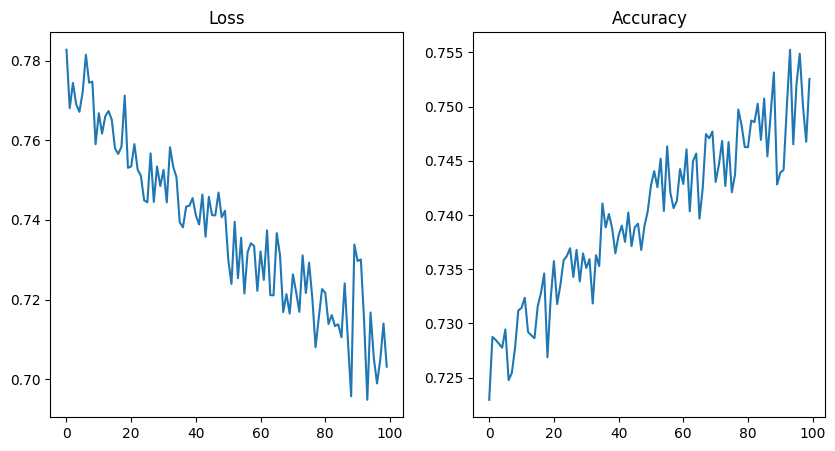

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_loss_history)
axs[0].set_title('Loss')
axs[1].plot(train_acc_history)
axs[1].set_title('Accuracy')
plt.show()

In [67]:
# testing
model.eval()
test_loss_history = []
test_acc_history = []
for epoch in tqdm(range(config['epochs'])):
    running_loss = 0.0
    running_acc = 0.0
    for i, (images, labels) in enumerate(test_dataloader):
        images, labels = images.to(config['device']), labels.to(config['device'])
        output = model(images)
        loss = criterion(output, labels)
        running_loss += loss.item()
        preds = torch.argmax(output, 1)
        running_acc += (preds == labels).float().mean()
    test_loss = running_loss / len(test_dataloader)
    test_acc = running_acc / len(test_dataloader)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc.item())
    print(f'Epoch {epoch+1}/{config["epochs"]} Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

  1%|          | 1/100 [00:02<03:30,  2.13s/it]

Epoch 1/100 Loss: 1.3837 Acc: 0.5899


  2%|▏         | 2/100 [00:04<03:29,  2.13s/it]

Epoch 2/100 Loss: 1.4043 Acc: 0.5870


  3%|▎         | 3/100 [00:06<03:15,  2.02s/it]

Epoch 3/100 Loss: 1.3628 Acc: 0.5943


  4%|▍         | 4/100 [00:08<03:17,  2.05s/it]

Epoch 4/100 Loss: 1.3703 Acc: 0.5914


  5%|▌         | 5/100 [00:10<03:11,  2.01s/it]

Epoch 5/100 Loss: 1.3918 Acc: 0.5914


  6%|▌         | 6/100 [00:12<03:13,  2.06s/it]

Epoch 6/100 Loss: 1.3854 Acc: 0.5855


  7%|▋         | 7/100 [00:14<03:02,  1.96s/it]

Epoch 7/100 Loss: 1.3953 Acc: 0.5899


  8%|▊         | 8/100 [00:16<03:08,  2.05s/it]

Epoch 8/100 Loss: 1.3723 Acc: 0.5914


  9%|▉         | 9/100 [00:18<03:04,  2.02s/it]

Epoch 9/100 Loss: 1.3859 Acc: 0.5899


 10%|█         | 10/100 [00:20<03:02,  2.03s/it]

Epoch 10/100 Loss: 1.3796 Acc: 0.5929


 11%|█         | 11/100 [00:22<02:59,  2.02s/it]

Epoch 11/100 Loss: 1.3813 Acc: 0.5929


 12%|█▏        | 12/100 [00:24<02:55,  1.99s/it]

Epoch 12/100 Loss: 1.4007 Acc: 0.5841


 13%|█▎        | 13/100 [00:26<02:58,  2.05s/it]

Epoch 13/100 Loss: 1.3967 Acc: 0.5899


 14%|█▍        | 14/100 [00:28<02:52,  2.01s/it]

Epoch 14/100 Loss: 1.3872 Acc: 0.5899


 15%|█▌        | 15/100 [00:30<02:52,  2.03s/it]

Epoch 15/100 Loss: 1.3913 Acc: 0.5870


 16%|█▌        | 16/100 [00:32<02:44,  1.95s/it]

Epoch 16/100 Loss: 1.3866 Acc: 0.5885


 17%|█▋        | 17/100 [00:34<02:43,  1.97s/it]

Epoch 17/100 Loss: 1.3761 Acc: 0.5885


 18%|█▊        | 18/100 [00:36<02:39,  1.95s/it]

Epoch 18/100 Loss: 1.3762 Acc: 0.5899


 19%|█▉        | 19/100 [00:37<02:31,  1.87s/it]

Epoch 19/100 Loss: 1.3726 Acc: 0.5899


 20%|██        | 20/100 [00:39<02:28,  1.86s/it]

Epoch 20/100 Loss: 1.3764 Acc: 0.5914


 21%|██        | 21/100 [00:41<02:25,  1.84s/it]

Epoch 21/100 Loss: 1.3866 Acc: 0.5914


 22%|██▏       | 22/100 [00:43<02:28,  1.90s/it]

Epoch 22/100 Loss: 1.3743 Acc: 0.5929


 23%|██▎       | 23/100 [00:45<02:25,  1.89s/it]

Epoch 23/100 Loss: 1.3886 Acc: 0.5855


 24%|██▍       | 24/100 [00:47<02:25,  1.91s/it]

Epoch 24/100 Loss: 1.3759 Acc: 0.5914


 25%|██▌       | 25/100 [00:49<02:19,  1.87s/it]

Epoch 25/100 Loss: 1.3941 Acc: 0.5855


 26%|██▌       | 26/100 [00:51<02:20,  1.89s/it]

Epoch 26/100 Loss: 1.3851 Acc: 0.5929


 27%|██▋       | 27/100 [00:52<02:15,  1.85s/it]

Epoch 27/100 Loss: 1.4000 Acc: 0.5885


 28%|██▊       | 28/100 [00:54<02:12,  1.85s/it]

Epoch 28/100 Loss: 1.3932 Acc: 0.5870


 29%|██▉       | 29/100 [00:56<02:13,  1.89s/it]

Epoch 29/100 Loss: 1.3844 Acc: 0.5929


 30%|███       | 30/100 [00:58<02:13,  1.91s/it]

Epoch 30/100 Loss: 1.3911 Acc: 0.5914


 31%|███       | 31/100 [01:00<02:14,  1.95s/it]

Epoch 31/100 Loss: 1.3746 Acc: 0.5899


 32%|███▏      | 32/100 [01:02<02:12,  1.94s/it]

Epoch 32/100 Loss: 1.3784 Acc: 0.5914


 33%|███▎      | 33/100 [01:04<02:11,  1.97s/it]

Epoch 33/100 Loss: 1.3804 Acc: 0.5914


 34%|███▍      | 34/100 [01:06<02:09,  1.97s/it]

Epoch 34/100 Loss: 1.3906 Acc: 0.5899


 35%|███▌      | 35/100 [01:08<02:08,  1.97s/it]

Epoch 35/100 Loss: 1.4092 Acc: 0.5885


 36%|███▌      | 36/100 [01:10<02:07,  1.98s/it]

Epoch 36/100 Loss: 1.3878 Acc: 0.5899


 37%|███▋      | 37/100 [01:12<02:03,  1.95s/it]

Epoch 37/100 Loss: 1.3825 Acc: 0.5885


 38%|███▊      | 38/100 [01:14<02:01,  1.96s/it]

Epoch 38/100 Loss: 1.3815 Acc: 0.5914


 39%|███▉      | 39/100 [01:16<01:59,  1.96s/it]

Epoch 39/100 Loss: 1.3723 Acc: 0.5885


 40%|████      | 40/100 [01:18<01:57,  1.95s/it]

Epoch 40/100 Loss: 1.3895 Acc: 0.5899


 41%|████      | 41/100 [01:20<01:54,  1.93s/it]

Epoch 41/100 Loss: 1.3702 Acc: 0.5929


 42%|████▏     | 42/100 [01:22<01:54,  1.97s/it]

Epoch 42/100 Loss: 1.3747 Acc: 0.5929


 43%|████▎     | 43/100 [01:24<01:52,  1.98s/it]

Epoch 43/100 Loss: 1.3828 Acc: 0.5899


 44%|████▍     | 44/100 [01:25<01:46,  1.89s/it]

Epoch 44/100 Loss: 1.3935 Acc: 0.5885


 45%|████▌     | 45/100 [01:28<01:47,  1.96s/it]

Epoch 45/100 Loss: 1.3979 Acc: 0.5870


 46%|████▌     | 46/100 [01:30<01:46,  1.97s/it]

Epoch 46/100 Loss: 1.3846 Acc: 0.5914


 47%|████▋     | 47/100 [01:32<01:46,  2.00s/it]

Epoch 47/100 Loss: 1.3835 Acc: 0.5914


 48%|████▊     | 48/100 [01:34<01:43,  1.99s/it]

Epoch 48/100 Loss: 1.3972 Acc: 0.5899


 49%|████▉     | 49/100 [01:36<01:51,  2.18s/it]

Epoch 49/100 Loss: 1.3782 Acc: 0.5914


 50%|█████     | 50/100 [01:39<01:59,  2.40s/it]

Epoch 50/100 Loss: 1.3804 Acc: 0.5929


 51%|█████     | 51/100 [01:41<01:54,  2.33s/it]

Epoch 51/100 Loss: 1.3670 Acc: 0.5958


 52%|█████▏    | 52/100 [01:44<01:51,  2.31s/it]

Epoch 52/100 Loss: 1.3999 Acc: 0.5885


 53%|█████▎    | 53/100 [01:46<01:49,  2.32s/it]

Epoch 53/100 Loss: 1.3773 Acc: 0.5973


 54%|█████▍    | 54/100 [01:48<01:46,  2.32s/it]

Epoch 54/100 Loss: 1.3847 Acc: 0.5914


 55%|█████▌    | 55/100 [01:50<01:43,  2.29s/it]

Epoch 55/100 Loss: 1.3759 Acc: 0.5914


 56%|█████▌    | 56/100 [01:53<01:39,  2.26s/it]

Epoch 56/100 Loss: 1.3753 Acc: 0.5929


 57%|█████▋    | 57/100 [01:55<01:35,  2.21s/it]

Epoch 57/100 Loss: 1.3661 Acc: 0.5943


 58%|█████▊    | 58/100 [01:57<01:32,  2.20s/it]

Epoch 58/100 Loss: 1.3755 Acc: 0.5914


 59%|█████▉    | 59/100 [01:59<01:30,  2.20s/it]

Epoch 59/100 Loss: 1.3877 Acc: 0.5899


 60%|██████    | 60/100 [02:01<01:26,  2.15s/it]

Epoch 60/100 Loss: 1.3968 Acc: 0.5899


 61%|██████    | 61/100 [02:03<01:23,  2.15s/it]

Epoch 61/100 Loss: 1.3882 Acc: 0.5885


 62%|██████▏   | 62/100 [02:05<01:21,  2.14s/it]

Epoch 62/100 Loss: 1.3714 Acc: 0.5914


 63%|██████▎   | 63/100 [02:07<01:17,  2.09s/it]

Epoch 63/100 Loss: 1.3968 Acc: 0.5885


 64%|██████▍   | 64/100 [02:09<01:14,  2.07s/it]

Epoch 64/100 Loss: 1.3697 Acc: 0.5914


 65%|██████▌   | 65/100 [02:11<01:11,  2.05s/it]

Epoch 65/100 Loss: 1.3652 Acc: 0.5973


 66%|██████▌   | 66/100 [02:13<01:07,  1.99s/it]

Epoch 66/100 Loss: 1.3730 Acc: 0.5929


 67%|██████▋   | 67/100 [02:15<01:06,  2.02s/it]

Epoch 67/100 Loss: 1.3784 Acc: 0.5899


 68%|██████▊   | 68/100 [02:17<01:04,  2.03s/it]

Epoch 68/100 Loss: 1.3796 Acc: 0.5885


 69%|██████▉   | 69/100 [02:19<01:03,  2.06s/it]

Epoch 69/100 Loss: 1.3765 Acc: 0.5914


 70%|███████   | 70/100 [02:22<01:02,  2.09s/it]

Epoch 70/100 Loss: 1.4020 Acc: 0.5826


 71%|███████   | 71/100 [02:24<01:00,  2.09s/it]

Epoch 71/100 Loss: 1.3890 Acc: 0.5914


 72%|███████▏  | 72/100 [02:26<00:58,  2.10s/it]

Epoch 72/100 Loss: 1.3831 Acc: 0.5870


 73%|███████▎  | 73/100 [02:28<00:56,  2.07s/it]

Epoch 73/100 Loss: 1.3740 Acc: 0.5929


 74%|███████▍  | 74/100 [02:30<00:54,  2.10s/it]

Epoch 74/100 Loss: 1.3837 Acc: 0.5855


 75%|███████▌  | 75/100 [02:33<00:55,  2.23s/it]

Epoch 75/100 Loss: 1.3708 Acc: 0.5943


 76%|███████▌  | 76/100 [02:35<00:54,  2.27s/it]

Epoch 76/100 Loss: 1.3717 Acc: 0.5943


 77%|███████▋  | 77/100 [02:37<00:51,  2.24s/it]

Epoch 77/100 Loss: 1.4040 Acc: 0.5885


 78%|███████▊  | 78/100 [02:39<00:49,  2.25s/it]

Epoch 78/100 Loss: 1.3843 Acc: 0.5885


 79%|███████▉  | 79/100 [02:42<00:47,  2.25s/it]

Epoch 79/100 Loss: 1.3875 Acc: 0.5899


 80%|████████  | 80/100 [02:44<00:43,  2.19s/it]

Epoch 80/100 Loss: 1.3869 Acc: 0.5899


 81%|████████  | 81/100 [02:46<00:42,  2.21s/it]

Epoch 81/100 Loss: 1.3969 Acc: 0.5899


 82%|████████▏ | 82/100 [02:48<00:38,  2.16s/it]

Epoch 82/100 Loss: 1.3732 Acc: 0.5929


 83%|████████▎ | 83/100 [02:50<00:37,  2.18s/it]

Epoch 83/100 Loss: 1.3785 Acc: 0.5914


 84%|████████▍ | 84/100 [02:53<00:35,  2.23s/it]

Epoch 84/100 Loss: 1.3724 Acc: 0.5885


 85%|████████▌ | 85/100 [02:55<00:34,  2.31s/it]

Epoch 85/100 Loss: 1.3972 Acc: 0.5885


 86%|████████▌ | 86/100 [02:58<00:32,  2.35s/it]

Epoch 86/100 Loss: 1.3820 Acc: 0.5914


 87%|████████▋ | 87/100 [03:00<00:30,  2.37s/it]

Epoch 87/100 Loss: 1.3924 Acc: 0.5899


 88%|████████▊ | 88/100 [03:03<00:29,  2.44s/it]

Epoch 88/100 Loss: 1.3862 Acc: 0.5914


 89%|████████▉ | 89/100 [03:05<00:26,  2.41s/it]

Epoch 89/100 Loss: 1.4004 Acc: 0.5899


 90%|█████████ | 90/100 [03:07<00:23,  2.36s/it]

Epoch 90/100 Loss: 1.4009 Acc: 0.5841


 91%|█████████ | 91/100 [03:09<00:20,  2.28s/it]

Epoch 91/100 Loss: 1.3789 Acc: 0.5914


 92%|█████████▏| 92/100 [03:11<00:18,  2.25s/it]

Epoch 92/100 Loss: 1.3824 Acc: 0.5899


 93%|█████████▎| 93/100 [03:14<00:16,  2.32s/it]

Epoch 93/100 Loss: 1.3941 Acc: 0.5855


 94%|█████████▍| 94/100 [03:16<00:13,  2.27s/it]

Epoch 94/100 Loss: 1.3788 Acc: 0.5929


 95%|█████████▌| 95/100 [03:19<00:12,  2.43s/it]

Epoch 95/100 Loss: 1.3815 Acc: 0.5885


 96%|█████████▌| 96/100 [03:21<00:09,  2.47s/it]

Epoch 96/100 Loss: 1.3788 Acc: 0.5899


 97%|█████████▋| 97/100 [03:24<00:07,  2.38s/it]

Epoch 97/100 Loss: 1.3805 Acc: 0.5914


 98%|█████████▊| 98/100 [03:26<00:04,  2.29s/it]

Epoch 98/100 Loss: 1.3943 Acc: 0.5914


 99%|█████████▉| 99/100 [03:27<00:02,  2.13s/it]

Epoch 99/100 Loss: 1.3946 Acc: 0.5899


100%|██████████| 100/100 [03:30<00:00,  2.10s/it]

Epoch 100/100 Loss: 1.3869 Acc: 0.5929
